# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

import torch

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

print('Torch version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)

print("Is CUDA enabled?",torch.cuda.is_available())

device:  cpu
device_count:  0
Torch version:  2.8.0+cu126
torch.version.cuda:  12.6
Is CUDA enabled? False


# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'

GASS_data_path = gaskap_data_path / 'GASS'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

# Fcn

In [ ]:
# see paper GALAH DR4 https://arxiv.org/pdf/2409.19858 Section 7.2.2
vlsr_sun = 15.17 # km/s


# Create velocity range around the central velocity
velocity_range = np.linspace(-100., 100., 500)

# Define the Gaussian function
def gaussian(x, amp, center, std):
    return amp * np.exp(-(x - center)**2 / (2 * std**2))

In [ ]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def download_galah_data(save_path, sobject_id):
    sobject_id = str(sobject_id)
    output_star_id_file = save_path / f'{sobject_id}_allstar_fit_spectrum.fits'
    # print(output_star_id_file)
    save_path = str(save_path)

    if not os.path.exists(output_star_id_file):
        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_spectrum.fits'
        wget.download(url, out=save_path)

        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_comparison.pdf'
        wget.download(url, out=save_path)

In [ ]:
def rv_to_lsr(ra, dec, rv, u_sun=11.10, v_sun=12.24, w_sun=7.25):
    """
    Convert heliocentric radial velocities to the Local Standard of Rest (LSR).

    Parameters:
    -----------
    ra : float or array-like
        Right Ascension in degrees
    dec : float or array-like
        Declination in degrees
    rv : float or array-like
        Heliocentric radial velocity in km/s
    u_sun : float, optional
        Solar motion in km/s toward the Galactic center
    v_sun : float, optional
        Solar motion in km/s in direction of Galactic rotation
    w_sun : float, optional
        Solar motion in km/s toward the North Galactic Pole

    Returns:
    --------
    float or array-like
        Radial velocity in the LSR frame in km/s
    """
    # Create SkyCoord object
    coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

    # Convert to Galactic coordinates
    l = coords.galactic.l.radian
    b = coords.galactic.b.radian

    # Calculate projection of solar motion
    proj_sun_vel = (
        u_sun * np.cos(b) * np.cos(l) +
        v_sun * np.cos(b) * np.sin(l) +
        w_sun * np.sin(b)
    )

    # Convert to LSR
    rv_lsr = rv + proj_sun_vel

    return rv_lsr







def rv_to_lsr_lb(glon, glat, rv, u_sun=11.10, v_sun=12.24, w_sun=7.25):
    """
    Convert heliocentric radial velocities to the Local Standard of Rest (LSR).

    Schönrich et al. (2010): https://academic.oup.com/mnras/article/403/4/1829/1054839
    and https://www.aanda.org/articles/aa/pdf/2024/09/aa50936-24.pdf

    Parameters:
    -----------
    glon : float or array-like
        Galactic longitude in degrees
    glat : float or array-like
        Galactic latitude in degrees
    rv : float or array-like
        Heliocentric radial velocity in km/s
    u_sun : float, optional
        Solar motion in km/s toward the Galactic center
    v_sun : float, optional
        Solar motion in km/s in direction of Galactic rotation
    w_sun : float, optional
        Solar motion in km/s toward the North Galactic Pole

    Returns:
    --------
    float or array-like
        Radial velocity in the LSR frame in km/s
    """
    # Convert to Galactic coordinates
    l = np.radians(glon)
    b = np.radians(glat)

    # Calculate projection of solar motion
    proj_sun_vel = (
        u_sun * np.cos(b) * np.cos(l) +
        v_sun * np.cos(b) * np.sin(l) +
        w_sun * np.sin(b)
    )

    # Convert to LSR
    rv_lsr = rv + proj_sun_vel

    return rv_lsr

In [ ]:
def wavelength_to_rv(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity from observed and rest wavelengths using the
    relativistic Doppler formula.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    # Convert wavelengths to float if they're strings
    wavelength_obs = np.float64(wavelength_obs)
    wavelength_rest = np.float64(wavelength_rest)

    # Calculate velocity using relativistic formula
    c = const.c.to('km/s').value  # speed of light in km/s

    # (λ_obs / λ_rest)^2 = (1 + v/c)/(1 - v/c)
    # Solving for v:
    z = wavelength_obs / wavelength_rest
    rv = c * (z**2 - 1) / (z**2 + 1)

    return rv

def wavelength_to_rv_simple(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity using the simple (non-relativistic) Doppler formula.
    Use this only for v << c.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    c = const.c.to('km/s').value  # speed of light in km/s

    # Simple Doppler formula: v/c = Δλ/λ
    # rv = c * (wavelength_obs - wavelength_rest) / wavelength_rest
    rv = c * (wavelength_obs - wavelength_rest) / wavelength_obs

    return rv

In [ ]:
def wavelength_to_vlsrk(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1 - rest_wavelength / observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk


# vlsrk_velocities = wavelength_to_vlsrk(observed_wavelengths_angstroms, rest_wavelength_angstroms, galactic_l, galactic_b)

In [ ]:
def wavelength_to_vlsrk_with_galah_correction(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        galah_allstar['rv_comp_1']: See GALAH
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1. - rest_wavelength / observed_wavelengths) + rv_comp_1
    # vrad = c * (1. - rest_wavelength/observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    # vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    # vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)
    vlsrk = vrad + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk


# vlsrk_velocities = wavelength_to_vlsrk(observed_wavelengths_angstroms, rest_wavelength_angstroms, galactic_l, galactic_b)

In [ ]:
def binned_median(x: np.ndarray, y: np.ndarray, bin_edges: np.ndarray, n_resamples = 1000):
    from scipy import stats

    # Calculate the bin average using scipy
    bin_avg, _, _ = stats.binned_statistic(x, y, statistic='median', bins=bin_edges)

    # Container for bin averages
    bin_avg_arr = []

    # Perform bootstrap resampling and calculate bin averages
    for _ in range(n_resamples):
        resample_indices = np.random.choice(len(y), size=len(y), replace=True)
        resample_y= y[resample_indices]
        bin_avg_resample, _, _ = stats.binned_statistic(x, resample_y, statistic='median', bins=bin_edges)
        bin_avg_arr.append(bin_avg_resample)

    # Compute the upper and lower percentiles of the bin averages
    bin_avg_arr = np.array(bin_avg_arr)
    bin_mean_arr = np.mean(bin_avg_arr, axis=0)
    bin_avg_upper = np.percentile(bin_avg_arr, 97.5, axis=0) - bin_mean_arr + bin_avg
    bin_avg_lower = np.percentile(bin_avg_arr, 2.5, axis=0) - bin_mean_arr + bin_avg

    return bin_avg, bin_avg_upper, bin_avg_lower

In [ ]:
# Define the Gaussian function with FWHM
def gaussian(x, A, x0, FWHM):
    sigma = FWHM / 2.3548
    return A * np.exp(-(x-x0)**2 / (2*sigma**2))

In [ ]:
def compute_column_density_KI(W_lambda_angstrom):
    """
    Compute the column density for weak lines:

    \[
    W_{\lambda} = \frac{\pi e^2}{m_e c^2} f \lambda^2 N
    \]

    Where:

    - \( e \) is the electron charge
    - \( m_e \) is the electron mass
    - \( c \) is the speed of light
    - \( f \) is the oscillator strength of the transition
    - \( \lambda \) is the wavelength of the line

    """
    # f = 0.3393  # Oscillator strength
    f = 0.332 # Oscillator strength
    lambda_ = 7698.9643 * u.Angstrom  # Wavelength in Angstrom lambda_rest = 7698.9643 # Angstroms

    # Convert equivalent width from Angstrom to meters
    W_lambda_m = (W_lambda_angstrom * u.Angstrom).to(u.m)

    # Compute column density using the formula
    N = (W_lambda_m * const.m_e * const.c**2) / (np.pi * const.e.gauss**2 * f * lambda_.to(u.m)**2)

    return N.to(10**(10)/u.cm**2)  # This ensures the column density is returned in SI units (m^-2)

In [ ]:
def mollweide_histogram(ra, dec, distance, eq_width, bin_size=1000, nside=32):
    """
    Plots a histogram in Mollweide projection using HEALPix binning that shows the median
    equivalent width for bins of distances, in galactic coordinates.

    Parameters:
    - ra (array): Right ascension in degrees.
    - dec (array): Declination in degrees.
    - distance (array): Distance in parsec.
    - eq_width (array): Equivalent width in Å.
    - bin_size (int, optional): The size of the distance bins. Default is 200 parsecs.
    - nside (int, optional): The resolution of the HEALPix map. Default is 32.
    """
    # Convert equatorial coordinates (RA, Dec) to galactic coordinates (l, b)
    c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    l = c.galactic.l.degree
    b = c.galactic.b.degree

    # Convert (l, b) to HEALPix indices
    indices = hp.ang2pix(nside, l, b, lonlat=True)

    # Get maximum distance for binning
    max_dist = np.max(distance)

    # Create bins for distances
    bins = np.arange(0, max_dist + bin_size, bin_size)

    for i in range(len(bins) - 1)[:2]:
        mask = (distance >= 0) & (distance < bins[i+1])
        if np.any(mask):
            median_map = np.full(hp.nside2npix(nside), np.nan)
            for ind in np.unique(indices[mask]):
                median_map[ind] = np.median(eq_width[(indices == ind) & mask])

            hp.mollview(
                median_map,
                title=f'N(KI) 7699',
                cmap='plasma',
                min=7,max=21,
                badcolor='None',
                bgcolor='None',
                unit = r'N(KI) 7699 / $10^{10}\,\mathrm{cm^{-2}}$'
            )
            hp.graticule()

            plt.savefig('figures/n_k_'+str(i)+'.png',dpi=200,bbox_inches='tight', transparent=True)
            plt.show()
            plt.close()

# For plotting

In [ ]:

# Circle
def _circle(x, y, r):
    theta = np.linspace(0, 2*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_LMC = 279.
gb_LMC = -33.5
R_LMC = 5.

gl_SMC = 302.
gb_SMC = -44.5
R_SMC = 3.

LMC = dict(
    gl = gl_LMC,
    gb = gb_LMC,
    center = [gl_LMC, gb_LMC],
    glon_range = [270., 307.],
    glat_range = [-48., -25.],
    circ = _circle(gl_LMC, gb_LMC, R_LMC),
    name = 'Large Magellanic Cloud'
)


SMC = dict(
    gl = gl_SMC,
    gb = gb_SMC,
    center = [gl_SMC, gb_SMC],
    glon_range = [295., 315.],
    glat_range = [-50., -40.],
    circ = _circle(gl_SMC, gb_SMC, R_SMC),
    name = 'Small Magellanic Cloud'
)


# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = SMC['circ']
LMC_xcirc, LMC_ycirc = LMC['circ']

# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.87*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# Read GASKAP-HI absorption measurements: Pilot II data (all)

In [ ]:
hi_abs_all_filename = gaskap_hires_data_path / 'absdr3' / 'gaskap_abs_spectra_dr3b.csv'
print(hi_abs_all_filename)

abs_df = pd.read_csv(hi_abs_all_filename)
nmes, _ = abs_df.shape
print(f'Number of all sources {nmes}')
abs_df.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/absdr3/gaskap_abs_spectra_dr3b.csv
Number of all sources 2714


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,...,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,...,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,...,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,...,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


In [ ]:
non_hiabs_df = abs_df[abs_df.mw_detection == False]
non_hiabs_df

,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
8,24,J004327-704135,SB30665_component_11a,10.863942,-70.693260,303.888848,-46.420157,B,215.136993,332.138000,...,5.895,131.210007,2.227711e+20,False,0.000643,M344-11,30665,30665,False,False
10,26,J013229-723956,SB30665_component_12a,23.123198,-72.665757,298.690805,-44.122841,B,138.602005,138.981995,...,4.800,127.029999,1.083733e+21,False,0.002100,M344-06,30665,30665,False,False
11,28,J002919-754018,SB30665_component_13a,7.330447,-75.671738,304.752927,-41.378221,B,185.477005,206.205994,...,4.860,7.050000,1.705849e+20,False,0.002592,M344-11,30665,30665,False,False
12,29,J002920-754008,SB30665_component_13b,7.334793,-75.668999,304.751919,-41.381065,B,70.438004,70.567001,...,4.735,156.479996,1.705849e+20,False,0.000732,M344-11,30665,30665,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709,0,J045631-762533,SB38845_component_245a,74.132371,-76.425960,288.737278,-32.932020,C,18.582001,20.014000,...,4.195,40.980000,0.000000e+00,False,-0.001994,M000-02,"38509,38845",38845,False,False
2710,0,J045907-753153,SB38845_component_261a,74.779860,-75.531478,287.674258,-33.105855,C,17.294001,21.070000,...,4.570,51.529999,0.000000e+00,False,-0.000745,M000-02,"38758,38845",38845,False,False
2711,0,J045340-751015,SB38758_component_264a,73.419855,-75.170876,287.418567,-33.556039,C,15.995000,17.537001,...,4.195,57.150002,0.000000e+00,False,0.004325,M000-02,"38758,38845",38758,False,False
2712,0,J060302-715904,SB33047_component_273a,90.760142,-71.984682,282.615941,-29.427549,C,16.532000,17.809999,...,3.845,84.059998,0.000000e+00,False,-0.017450,M000-02,"33047,38845",33047,False,False


# Read GASKAP-HI absorption MW foreground: Pilot II data (detection)

In [ ]:
spectra_filename = gaskap_hires_result_path / 'result_table_dr3_integrated_properties.csv'
print(spectra_filename)
df_det = pd.read_csv(spectra_filename)
ndet, ncols = df_det.shape
print(f'Number of rows {ndet},\n Number of columns: {ncols}')
df_det.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/result_table_dr3_integrated_properties.csv
Number of rows 462,
 Number of columns: 45


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky,flux_int,ra_hr,tau_noise_per_channel
0,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,...,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342,179.488998,0.240077,0.014621
1,J002144-741500,30665,J002144-741500-30665,5.433208,-74.249829,305.669096,-42.720187,0,B,122.134003,...,0.139190,3.164146,0.399856,3.152547,0.179060,2,3.561425,132.397995,0.362214,0.028466
2,J002223-742825,30665,J002223-742825-30665,5.597676,-74.473760,305.562542,-42.505801,0,B,103.077003,...,0.093871,2.909353,0.249468,2.823752,0.085782,2,3.561425,206.740997,0.373178,0.019057
3,J002248-734007,30665,J002248-734007-30665,5.700254,-73.668709,305.692177,-43.305728,0,B,49.626999,...,0.084394,3.155461,0.213848,2.971679,0.125477,1,3.564467,49.803001,0.380017,0.057622
4,J002335-735529,30665,J002335-735529-30665,5.895892,-73.924770,305.565463,-43.060758,0,B,62.061001,...,0.093914,2.635446,0.234640,2.824470,0.128897,1,3.567508,61.556000,0.393059,0.018767


In [ ]:
glon_det = df_det['glon'].values
glat_det = df_det['glat'].values

# Read GASKAP-HI absorption CNM components

In [ ]:
cnm_filename = data_path / 'hires_result_CNM_components_dr3.csv'
print(cnm_filename)
df_cnm = pd.read_csv(cnm_filename)
nrows, ncols = df_cnm.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
df_cnm.head(5)

/content/gdrive/MyDrive/Colab Notebooks/gaia/data/hires_result_CNM_components_dr3.csv
Number of rows 691,
 Number of columns: 39


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406


In [ ]:
glon_cnm = df_cnm['glon'].values
glat_cnm = df_cnm['glat'].values

In [ ]:
vcencnm = df_cnm['cencnm'].values
vcencnm.shape

(691,)

# Read Galah data

In [ ]:
# For Doppler velocity (observed)
lambda_rest = 7698.9643 # Angstroms
c = const.c.to(u.km/u.s).value  # Speed of light in km/s
c

np.float64(299792.458)

In [ ]:
galah0 = Table.read(allstar_file)
# Limit GALAH data to measurements that actually have interstellar potassium (k_is) detected with an equivalent width &
# where we have distances 'r_med' to stars
med_dist_lim = 30_000. # pc
galah0 = galah0[np.isfinite(galah0['ew_k_is']) & np.isfinite(galah0['r_med']) & (galah0['r_med'] < med_dist_lim) ]

In [ ]:
galah_dynamics = Table.read(dynamics_file)
galah_dynamics = galah_dynamics[['tmass_id','V_UVW']]

# Join
galah0 = join(galah0, galah_dynamics, keys = 'tmass_id', metadata_conflicts='silent')

# Interstellar Material Maps: [270,310] [-46,-26]

In [ ]:
med_dist = galah0['r_med'].data
med_dist = np.array(med_dist, dtype='float32')

ra = galah0['ra'].data
dec = galah0['dec'].data

ew_k_is = galah0['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))


# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra, dec=dec, unit='degree')
ra = coords.ra.wrap_at(180 * u.deg).radian
dec = coords.dec.radian
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon = coords.galactic.l.value
glat = coords.galactic.b.value

In [ ]:
galah0.add_columns([glon*u.deg, glat*u.deg], names=['l', 'b'])

In [ ]:
galah = galah0[(glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > -80.) & (glat < lmc_glat[1]) & (med_dist > 0.) & np.isfinite(galah0['age'])]

In [ ]:
# Correct the ISM K line-of-sight velocity (measured in the stellar restframe, but not corrected for stellar RV yet)
# See Section 8.9, Bug of interstellar K velocity in Buder et al. (2025)
galah['rv_k_is'] += galah['rv_comp_1']

In [ ]:
# LSR velocities from Schoenrich et al (2010)
# U, V, W: represent the components of the Sun's peculiar velocity relative to the LSR.
# U: The Sun's velocity towards the Galactic center.
# V: The Sun's velocity in the direction of Galactic rotation.
# W: The Sun's velocity perpendicular to the Galactic plane.
U, V, W = 11.1, 12.24, 7.25  # km/s

# Calculate the projection of the Sun's velocity onto the line of sight (a velocity correction related to the LSR).
# v_sun_projection = U*np.cos(l)*np.cos(b) + V*np.sin(l)*np.cos(b) + W*np.sin(b)
galah['v_sun_projection'] = U*np.cos((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            V*np.sin((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            W*np.sin((galah['b']).to(u.radian))

# Apply velocity offset (a velocity correction related to the LSR) to get
galah['ki_vlsrk'] = galah['rv_k_is'] + galah['v_sun_projection']

In [ ]:
# Prepare a flipped Galactic longitude
galah['l_flip'] = galah['l'].copy()
galah['l_flip'][galah['l_flip'] < 180.] += 360.

In [ ]:
# Calculate all parameters for the radio reference system

# First let's reverse the RV to the observed KI wavelength
galah['lambda_k_is'] = (galah['rv_k_is']/c + 1.)*lambda_rest

# Now convert to the RV in the radio system
galah['rv_k_is_radio'] = c*(galah['lambda_k_is'] - lambda_rest) / galah['lambda_k_is']

# Then apply the LSR velocity correction
galah['ki_v_lsr_radio'] = galah['rv_k_is_radio'] + galah['v_sun_projection']

In [ ]:
galah_df = pd.DataFrame(np.array(galah['sobject_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec', 'V_UVW','l','b','v_sun_projection','ki_vlsrk','l_flip','lambda_k_is','rv_k_is_radio','ki_v_lsr_radio']))
galah_df

,sobject_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,V_UVW,l,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio
0,140713004601361,4685221429109310080,b'galah_main',182,b'allstar',56851.773438,0.001042,-75.687943,-37.697868,307.113381,-41.019988,-7.069331,-104.650508,307.113381,7696.458320,-97.612949,-104.682280
1,140711003901371,4634293351884119040,b'galah_main',411,b'allstar',56849.777344,0.014375,-80.592613,-34.638008,305.515414,-36.276474,-7.123088,2.011176,305.515414,7699.198877,9.133986,2.010898
2,140811005001160,4689447883087062784,b'galah_main',76,b'allstar',56880.710938,0.016250,-73.391861,-3.506775,307.934743,-43.233826,-7.027888,-1.188739,307.934743,7699.114255,5.839036,-1.188853
3,140811005001171,4689462520335582592,b'galah_main',76,b'allstar',56880.710938,0.018292,-73.218887,-15.143014,307.998606,-43.400444,-7.024397,-6.399740,307.998606,7698.980342,0.624655,-6.399742
4,140711003901061,4631183662419506048,b'galah_main',411,b'allstar',56849.777344,0.033167,-81.445580,-55.094646,305.255114,-35.449999,-7.127760,3.817190,305.255114,7699.245377,10.944551,3.816791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22401,140711003901032,6352336620255046912,b'galah_main',411,b'allstar',56849.777344,359.947052,-80.983002,-7.744434,305.409765,-35.895384,-7.122000,1.230774,305.409765,7699.178807,8.352541,1.230541
22402,150828004701380,6353031550259896064,b'galah_main',321,b'allstar',57262.667969,359.958282,-78.948608,25.830523,306.039658,-37.866417,-7.108079,-186.897080,306.039658,7694.347142,-179.896888,-187.004966
22403,141104003301215,6379489613954820864,b'galah_main',133,b'allstar',56965.511719,359.960754,-74.590111,-30.124155,307.515543,-42.075811,-7.047230,8.193784,307.515543,7699.355704,15.240239,8.193009
22404,140711003901037,6352328000257170048,b'galah_main',411,b'allstar',56849.777344,359.961639,-81.128830,-54.155178,305.362962,-35.754562,-7.123348,5.670360,305.362962,7699.292855,12.793162,5.669814


In [ ]:
med_dist = np.array(galah['r_med'].data, dtype='float32')

field_ids = np.array(galah['field_id'].data, dtype='int16')
star_ids = np.array(galah['sobject_id'].data, dtype='int64')

ra = galah['ra'].data
dec = galah['dec'].data

ew_k_is = galah['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))
rv_k_is = galah['rv_k_is']

ebv = galah['ebv']

glon = galah['l'].data
glat = galah['b'].data

# HI maps

In [ ]:
# Moment Maps
tb_file = data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
tb_peak_map, tb_hdr = fits.getdata(tb_file, header=True)
print(tb_peak_map.shape)

tb_w = WCS(tb_hdr)
print(tb_w)

(3500, 5100)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.7000000000004 -38.69999999999963 
CRPIX : 2550.0 1750.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00666666 0.00666666 
NAXIS : 5100  3500


# Read csv: GALAH stars with 3sigma KI detections

In [ ]:
galah_fg_df_csv_file = data_path / 'galah_fg_df_3sigma_v2.csv'
galah_fg_df = pd.read_csv(galah_fg_df_csv_file)
galah_fg_df

,sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,...,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio,ki_flux_std,ki_max_flux,yn
0,140711003901371,b'00000344-8035334',4634293351884119040,b'galah_main',411,b'allstar',56849.777,0.014375,-80.592613,0,...,-36.276474,-7.123088,2.011176,305.515414,7699.198877,9.133986,2.010898,0.013848,0.098077,True
1,140811005001160,b'00000392-7323306',4689447883087062784,b'galah_main',76,b'allstar',56880.710,0.016250,-73.391861,0,...,-43.233826,-7.027888,-1.188739,307.934743,7699.114255,5.839036,-1.188853,0.005235,0.061716,True
2,140711003901061,b'00000796-8126441',4631183662419506048,b'galah_main',411,b'allstar',56849.777,0.033167,-81.445580,0,...,-35.449999,-7.127760,3.817190,305.255114,7699.245377,10.944551,3.816791,0.013779,0.102848,True
3,140711003901030,b'00001085-8105228',4634208693785476224,b'galah_main',411,b'allstar',56849.777,0.045208,-81.089668,88,...,-35.795691,-7.126913,-39.625753,305.359306,7698.129698,-32.502364,-39.629277,0.011397,0.185799,True
4,140711003901040,b'00001107-8109523',4634205120372686848,b'galah_main',411,b'allstar',56849.777,0.046167,-81.164528,0,...,-35.723116,-7.127265,2.524415,305.336690,7699.212165,9.651369,2.524104,0.008755,0.062491,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14388,140711003901337,b'23594236-8005456',6352503234922863872,b'galah_main',411,b'allstar',56849.777,359.926544,-80.096031,0,...,-36.754029,-7.115741,3.941643,305.685802,7699.248264,11.056977,3.941235,0.005069,0.096033,True
14389,140711003901032,b'23594728-8058587',6352336620255046912,b'galah_main',411,b'allstar',56849.777,359.947052,-80.983002,0,...,-35.895384,-7.122000,1.230774,305.409765,7699.178807,8.352541,1.230541,0.009287,0.066870,True
14390,141104003301215,b'23595059-7435243',6379489613954820864,b'galah_main',133,b'allstar',56965.510,359.960754,-74.590111,0,...,-42.075811,-7.047230,8.193784,307.515543,7699.355704,15.240239,8.193009,0.027120,0.192828,True
14391,140711003901037,b'23595079-8107438',6352328000257170048,b'galah_main',411,b'allstar',56849.777,359.961639,-81.128830,0,...,-35.754562,-7.123348,5.670360,305.362962,7699.292855,12.793162,5.669814,0.013037,0.081280,True


In [ ]:
galah_fg_df.yn.value_counts()

,count
yn,
True,14005
False,388


In [ ]:
galah_fg_df = galah_fg_df[(galah_fg_df.yn == True) & (galah_fg_df.ew_k_is < 0.1) & (galah_fg_df.r_med > 300.) & (galah_fg_df.age > 0.1) & (galah_fg_df.ebv < 1.)]
galah_fg_df = galah_fg_df[~galah_fg_df['field_id'].isin([-1, 180, 7365, 7364, 7363, 177, 411, 339, 321, 245, 344, 7122, 7156, 7128, 1056, 7120, 1092, 7182, 291, 129, 7211, 7210, 7212, 7213, 211, 7157,  7139, 7141, 7142, 1162, 7143, 7129, 7129, 7075, 251, 182, 7075, 7074, 70, 95, 141, 233, 7140, 7127, 7121, 7132])]
galah_fg_df

,sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,...,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio,ki_flux_std,ki_max_flux,yn
1,140811005001160,b'00000392-7323306',4689447883087062784,b'galah_main',76,b'allstar',56880.710,0.016250,-73.391861,0,...,-43.233826,-7.027888,-1.188739,307.934743,7699.114255,5.839036,-1.188853,0.005235,0.061716,True
14,140811005001158,b'00003997-7324408',4689444721991132672,b'galah_main',76,b'allstar',56880.710,0.166458,-73.411392,0,...,-43.226604,-7.040703,-156.296929,307.870801,7695.131254,-149.330572,-156.371276,0.011303,0.048713,True
31,141104003301176,b'00013353-7507352',4688253298063925760,b'galah_main',133,b'allstar',56965.510,0.389625,-75.126442,64,...,-41.587645,-7.088786,-13.594460,307.181658,7698.797228,-6.505816,-13.594602,0.013159,0.220483,True
50,140811005001214,b'00025239-7244486',4689676031749549440,b'galah_main',76,b'allstar',56880.710,0.718417,-72.746864,0,...,-43.909958,-7.074136,0.649036,307.899173,7699.162639,7.722973,0.648837,0.020542,0.100018,True
60,141104003301192,b'00032909-7454367',4688271955401831936,b'galah_main',133,b'allstar',56965.510,0.871167,-74.910194,0,...,-41.828316,-7.121641,-119.332701,307.093460,7696.082610,-112.253075,-119.374716,0.013194,0.097278,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14322,150830005101047,b'23563626-7416286',6379498027794589184,b'galah_main',108,b'allstar',57264.656,359.151154,-74.274666,68,...,-42.318888,-6.977726,54.695458,307.915110,7700.548128,61.660499,54.682773,0.003251,0.103415,True
14335,150830005101019,b'23573140-7353222',6379538610941751808,b'galah_main',108,b'allstar',57264.656,359.380798,-73.889557,0,...,-42.706038,-6.987042,3.391834,307.981431,7699.230840,10.378516,3.391475,0.007457,0.046628,True
14339,150830005101013,b'23574295-7350011',6379540225849449600,b'galah_main',108,b'allstar',57264.656,359.428864,-73.833694,0,...,-42.763401,-6.989627,28.055406,307.985422,7699.864291,35.040936,28.051310,0.003477,0.027638,True
14342,150830005101037,b'23574973-7409592',6379505591233212416,b'galah_main',108,b'allstar',57264.656,359.457245,-74.166420,4,...,-42.446233,-6.999366,-37.725041,307.848393,7698.175235,-30.728825,-37.728191,0.003931,0.077047,True


In [ ]:
field_ids = galah_fg_df['field_id'].values
glon_fg = galah_fg_df['l'].values
glat_fg = galah_fg_df['b'].values

# Select stars within the GASKAP footbprint

In [ ]:
from shapely.geometry import Point, Polygon

30


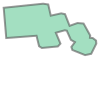

In [ ]:
gl_boundary = np.array([296.9,  300., 302.4,  305.,  304.9, 306., 307.3, 307.4, 305.4,  303., 298.,  297.6,  299., 297.4, 295.8,  295.,  291.5,  293.3, 292.3,  286., 284.9, 283.9, 272.0, 271., 286.5,  288.5, 289.5, 293.6, 295.1, 296.9])
gb_boundary = np.array([-36.5, -35.4, -35.6, -40.3, -41.2, -41.3, -42.3, -43.5, -47.5, -48.0, -46.0, -44.8, -42.9, -42.0, -38.40, -38.25, -39.2, -43.5, -44.6, -45.2, -44.5, -40.4, -41.3, -29.4, -27.8, -28.1, -32.5, -31.6, -31.9, -36.5])

print(len(gb_boundary))

polygon = Polygon(list(zip(gl_boundary, gb_boundary)))
polygon

In [ ]:
star_points = [Point(coord[0], coord[1]) for coord in list(zip(glon_fg, glat_fg))]
print(len(star_points))

10499


In [ ]:
# Check if the point is within the polygon
is_inside = polygon.contains(star_points)
is_inside

array([False, False, False, ..., False, False, False])

In [ ]:
galah_fg_df['in_footprint'] = False
galah_fg_df['in_footprint'] = is_inside

In [ ]:
galah_fg_df = galah_fg_df[galah_fg_df['in_footprint'] == True]
galah_fg_df

,sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,...,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio,ki_flux_std,ki_max_flux,yn,in_footprint
89,140811005001127,b'00051486-7342185',4688630464911368576,b'galah_main',76,b'allstar',56880.710,1.311958,-73.705139,0,...,-7.139463,45.652366,307.338332,7700.320046,52.782533,45.643071,0.014150,0.177816,True,True
93,141104003301237,b'00053290-7429138',4688345691400307968,b'galah_main',133,b'allstar',56965.510,1.387167,-74.487198,0,...,-7.155588,149.647559,307.054404,7702.991159,156.721175,149.565587,0.015002,0.109819,True,True
100,140811005001142,b'00061639-7317397',4689406136004906880,b'galah_main',76,b'allstar',56880.710,1.568375,-73.294388,0,...,-7.154802,-163.798632,307.377689,7694.941533,-156.725720,-163.880522,0.017935,0.060174,True,True
106,141104003301206,b'00062946-7447368',4688275769332764160,b'galah_main',133,b'allstar',56965.510,1.622792,-74.793587,0,...,-7.177003,11.936064,306.875019,7699.455142,19.111849,11.934846,0.012223,0.366652,True,True
107,140811005001119,b'00063294-7348470',4688614758214011776,b'galah_main',76,b'allstar',56880.710,1.637292,-73.813057,0,...,-7.167160,-20.148491,307.182166,7698.630927,-12.981893,-20.149053,0.009275,0.036324,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13797,170202000701090,b'06233799-7434160',5261838518223032064,b'tess_hermes',7172,b'allstar',57786.527,95.908333,-74.571136,0,...,-11.186415,3.648876,285.542251,7699.345285,14.834557,3.648141,0.013082,0.165350,True,True
13808,171205003601343,b'06235398-7549197',5261480279294717056,b'tess_hermes',7202,b'allstar',58092.668,95.974915,-75.822166,2048,...,-10.878975,-0.356924,286.958199,7699.234517,10.521682,-0.357293,0.095905,0.373720,True,True
13812,170202000701095,b'06240650-7512045',5261569614613157504,b'tess_hermes',7172,b'allstar',57786.527,96.027122,-75.201248,0,...,-11.031229,6.096956,286.255802,7699.404169,17.127207,6.095978,0.005800,0.091835,True,True
13816,170202000701093,b'06241247-7456104',5261768145181350400,b'tess_hermes',7172,b'allstar',57786.527,96.052040,-74.936249,0,...,-11.095769,4.128463,285.956142,7699.355273,15.223459,4.127690,0.005609,0.075003,True,True


In [ ]:
field_ids = galah_fg_df['field_id'].values
glon_fg = galah_fg_df['l'].values
glat_fg = galah_fg_df['b'].values

In [ ]:
# Get unique field IDs
unique_field_ids = np.unique(field_ids)

# Compute means for each field_id
field_lb_means = []
for field_id in unique_field_ids:
    mask = (field_ids == field_id)  # Mask rows with the current field_id
    glon_mean = np.mean(glon_fg[mask])
    glat_mean = np.mean(glat_fg[mask])
    field_lb_means.append((field_id, glon_mean, glat_mean))

# Print results
for field_id, glon_mean, glat_mean in field_lb_means:
    print(f"Field ID: {field_id}, Mean Glon: {glon_mean:.2f}, Mean Glat: {glat_mean:.2f}")

In [ ]:
ebv_ism_fg = galah_fg_df['ebv'].values
ew_ki_ism_fg = galah_fg_df['ew_k_is'].values
n_ki_ism_fg = np.array(compute_column_density_KI(ew_ki_ism_fg))

In [ ]:
stats_series = pd.DataFrame(ew_ki_ism_fg).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,9822.000000
mean,0.023418
std,0.015877
min,0.002573
25%,0.012593
50%,0.018498
75%,0.028628
max,0.099616


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 2)
x_std = round(series_values[2], 2)
x_minval = round(series_values[3], 4)
x_maxval = round(series_values[-1], 2)
x_median = round(series_values[5], 2)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

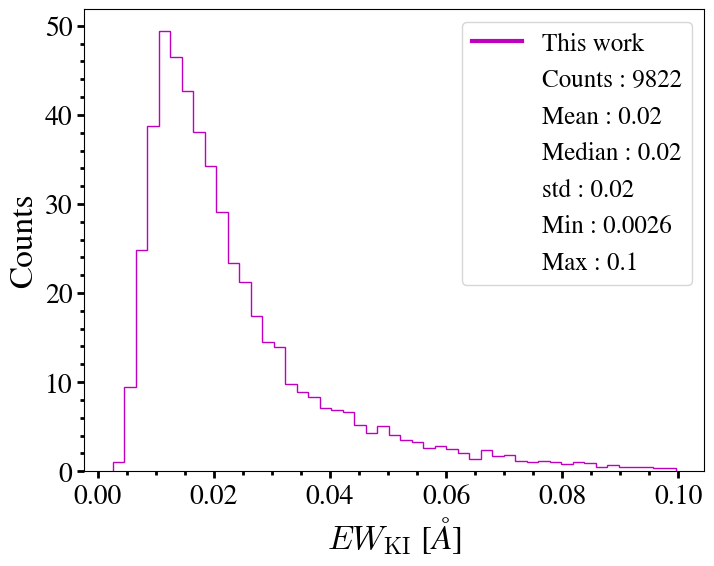

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(ew_ki_ism_fg, bins=np.linspace(np.nanmin(ew_ki_ism_fg), np.nanmax(ew_ki_ism_fg), 50),
         density=True, color='m', histtype='step',
         alpha=1., ls='-', lw=50,
         label='')

ploti, = plt.plot([], [], 'm-', lw=3, label=f'This work')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'$EW_\mathrm{KI}$ [$\AA$]', fontsize=24)
plt.ylabel(r'Counts', fontsize=24)

plt.legend(loc='upper right', fontsize=18)
plt.show()

In [ ]:
stats_series = pd.DataFrame(ebv_ism_fg).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,9822.000000
mean,0.109033
std,0.098211
min,0.026400
25%,0.060500
50%,0.089650
75%,0.116100
max,0.987100


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 2)
x_std = round(series_values[2], 2)
x_minval = round(series_values[3], 4)
x_maxval = round(series_values[-1], 2)
x_median = round(series_values[5], 2)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

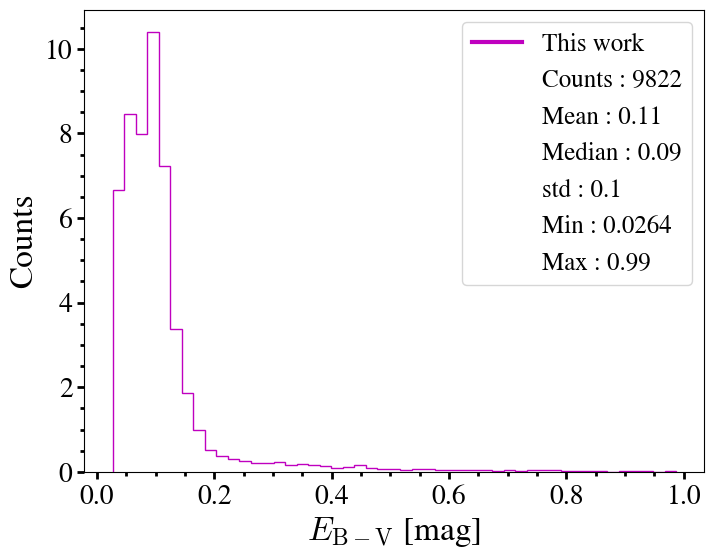

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(ebv_ism_fg, bins=np.linspace(np.nanmin(ebv_ism_fg), np.nanmax(ebv_ism_fg), 50),
         density=True, color='m', histtype='step',
         alpha=1., ls='-', lw=50,
         label='')

ploti, = plt.plot([], [], 'm-', lw=3, label=f'This work')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'$E_\mathrm{B - V}$ [mag]', fontsize=24)
plt.ylabel(r'Counts', fontsize=24)

plt.legend(loc='upper right', fontsize=18)
plt.show()

In [ ]:
stats_series = pd.DataFrame(n_ki_ism_fg).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,9822.000000
mean,13.442034
std,9.113646
min,1.476663
25%,7.228513
50%,10.617977
75%,16.432608
max,57.180221


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 2)
x_std = round(series_values[2], 2)
x_minval = round(series_values[3], 4)
x_maxval = round(series_values[-1], 2)
x_median = round(series_values[5], 2)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

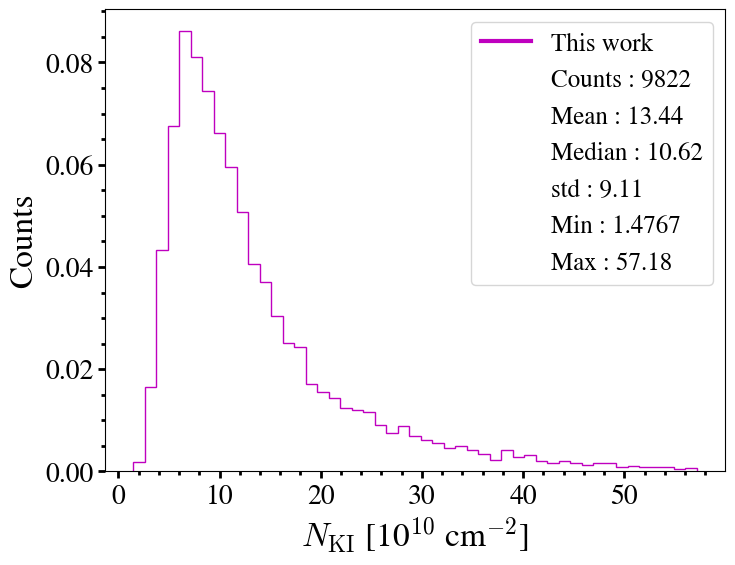

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(n_ki_ism_fg, bins=np.linspace(np.nanmin(n_ki_ism_fg), np.nanmax(n_ki_ism_fg), 50),
         density=True, color='m', histtype='step',
         alpha=1., ls='-', lw=50,
         label='')

ploti, = plt.plot([], [], 'm-', lw=3, label=f'This work')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'$N_\mathrm{KI}$ [10$^{10}$ cm$^{-2}$]', fontsize=24)
plt.ylabel(r'Counts', fontsize=24)

plt.legend(loc='upper right', fontsize=18)
plt.show()

# Plot: LOS/Sources on NHI maps

In [ ]:
# NHI Map
gaskap_nhi_file = gaskap_data_path / 'nhi_thin_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
gaskap_nhi, gaskap_nhi_hdr = fits.getdata(gaskap_nhi_file, header=True)
print(gaskap_nhi.shape)

gaskap_nhi_w = WCS(gaskap_nhi_hdr)
print(gaskap_nhi_w)


gaskap_nhi[gaskap_nhi < 0.] = 0.

(3500, 5100)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.7000000000004 -38.69999999999962 
CRPIX : 2550.0 1750.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00666666 0.00666666 
NAXIS : 5100  3500


In [ ]:
galah_gl_coords = SkyCoord(glon_fg, glat_fg, frame='galactic', unit='deg')
print(galah_gl_coords)

<SkyCoord (Galactic): (l, b) in deg
    [(307.33833223, -43.02568216), (307.05440437, -42.27173884),
     (307.37768948, -43.44185215), ..., (286.25580239, -27.89819627),
     (285.95614173, -27.88716795), (286.33041094, -27.8459304 )]>


In [ ]:
galah_x, galah_y = galah_gl_coords.to_pixel(wcs=gaskap_nhi_w)
galah_x

array([ 358.49744728,  365.9011757 ,  368.1337588 , ..., 2743.92953736,
       2784.42129954, 2733.97861841])

In [ ]:
galah_x = np.round(galah_x).astype(int)
galah_y = np.round(galah_y).astype(int)
print(galah_x)
print(galah_y)

print(galah_x[0])
print(galah_y[0])

[ 358  366  368 ... 2744 2784 2734]
[ 839  962  775 ... 3388 3389 3396]
358
839


In [ ]:
gaskap_nhi_map_arr = np.array(gaskap_nhi.flatten(), dtype='float')
stats_series = pd.DataFrame(gaskap_nhi_map_arr).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,1.785000e+07
mean,4.465604e+00
std,2.321322e+00
min,0.000000e+00
25%,2.521571e+00
50%,4.065871e+00
75%,6.184372e+00
max,1.905308e+01


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 2)
x_std = round(series_values[2], 2)
x_minval = round(series_values[3], 4)
x_maxval = round(series_values[-1], 2)
x_median = round(series_values[5], 2)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

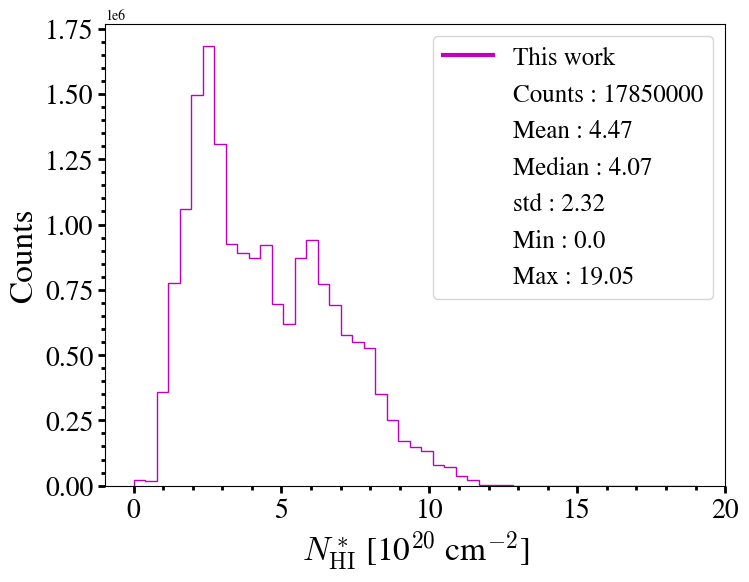

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(gaskap_nhi_map_arr, bins=np.linspace(np.nanmin(gaskap_nhi_map_arr), np.nanmax(gaskap_nhi_map_arr), 50),
         density=False, color='m', histtype='step',
         alpha=1., ls='-', lw=50,
         label='')

ploti, = plt.plot([], [], 'm-', lw=3, label=f'This work')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'$N^*_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=24)
plt.ylabel(r'Counts', fontsize=24)

plt.legend(loc='upper right', fontsize=18)
plt.show()

In [ ]:
gaskap_nhi_thin = np.zeros_like(ew_ki_ism_fg)
for jj, (galah_xi, galah_yi) in enumerate(zip(galah_x, galah_y)):
    gaskap_nhi_thin[jj] = gaskap_nhi[galah_yi, galah_xi]

In [ ]:
import scipy
print('nhi vs ew: pearson coefficient', scipy.stats.pearsonr(gaskap_nhi_thin, ew_ki_ism_fg))    # Pearson's r
print('nhi vs ew: spearman coefficient', scipy.stats.spearmanr(gaskap_nhi_thin, ew_ki_ism_fg))    # spearmanr's r

nhi vs ew: pearson coefficient PearsonRResult(statistic=np.float64(0.29184776298658116), pvalue=np.float64(4.070714151675873e-192))
nhi vs ew: spearman coefficient SignificanceResult(statistic=np.float64(0.3595965746218656), pvalue=np.float64(1.2038337615286835e-297))


In [ ]:
sel_idx = np.where((gaskap_nhi_thin > 0.) & (gaskap_nhi_thin < 14.))[0]
len(sel_idx)

9821

In [ ]:
statpr, statpp = scipy.stats.pearsonr(ebv_ism_fg, n_ki_ism_fg)
statspr, statspp = scipy.stats.spearmanr(ebv_ism_fg, n_ki_ism_fg)
print('tbpeak vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('tbpeak vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

tbpeak vs nki: pearson coefficient, statistic = 0.07642251144491849 , p-value = 3.349106569980857e-14
tbpeak vs nki: spearman coefficient, statistic = 0.3042775578761515 , p-value = 1.7774600950757383e-209


In [ ]:
statpr, statpp = scipy.stats.pearsonr(gaskap_nhi_thin[sel_idx], n_ki_ism_fg[sel_idx])
statspr, statspp = scipy.stats.spearmanr(gaskap_nhi_thin[sel_idx], n_ki_ism_fg[sel_idx])
print('nhi vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('nhi vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

nhi vs nki: pearson coefficient, statistic = 0.2919219524136203 , p-value = 3.372642210451496e-192
nhi vs nki: spearman coefficient, statistic = 0.35969358089835995 , p-value = 8.702910494760537e-298


In [ ]:
ki_hi_ratio = n_ki_ism_fg[sel_idx] / gaskap_nhi_thin[sel_idx]
ki_hi_ratio

array([8.82471074, 4.08255212, 5.49250112, ..., 1.88457273, 1.61056326,
       1.12745484])

In [ ]:
idx = np.where((ki_hi_ratio > 0.) & (ki_hi_ratio < 50.))
ki_hi_ratio_ok = ki_hi_ratio[idx]
gaskap_nhi_thin_ok = gaskap_nhi_thin[idx]

In [ ]:
stats_series = pd.DataFrame(ki_hi_ratio_ok).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,9821.000000
mean,2.781584
std,2.137411
min,0.261941
25%,1.521582
50%,2.190110
75%,3.306702
max,41.131644


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 2)
x_std = round(series_values[2], 2)
x_minval = round(series_values[3], 4)
x_maxval = round(series_values[-1], 2)
x_median = round(series_values[5], 2)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

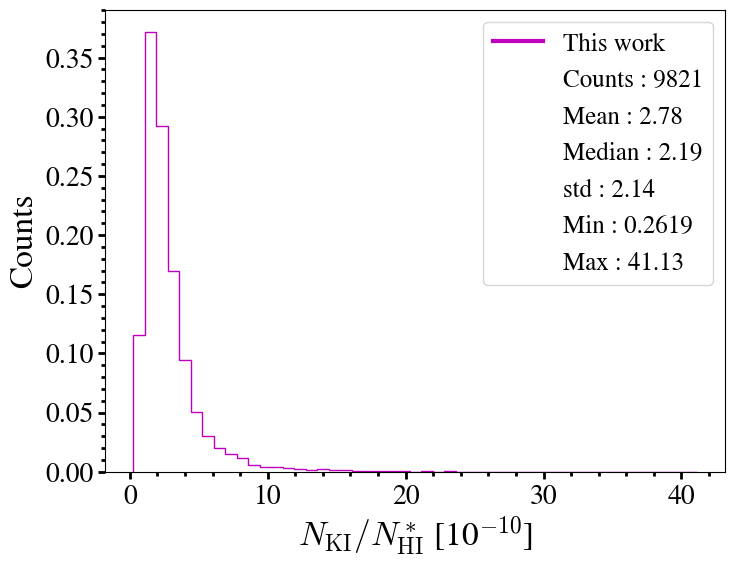

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(ki_hi_ratio_ok, bins=np.linspace(np.nanmin(ki_hi_ratio_ok), np.nanmax(ki_hi_ratio_ok), 50),
         density=True, color='m', histtype='step',
         alpha=1., ls='-', lw=50,
         label='')

ploti, = plt.plot([], [], 'm-', lw=3, label=f'This work')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'$N_\mathrm{KI} / N^*_\mathrm{HI}$ [10$^{-10}$]', fontsize=24)
plt.ylabel(r'Counts', fontsize=24)

plt.legend(loc='upper right', fontsize=18)
plt.show()

# Tb peak

In [ ]:
tb_peak_map_arr = np.array(tb_peak_map.flatten(), dtype='float')
stats_series = pd.DataFrame(tb_peak_map_arr).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,1.785000e+07
mean,1.909403e+01
std,1.260757e+01
min,1.061594e+00
25%,7.732034e+00
50%,1.630207e+01
75%,2.980687e+01
max,9.916620e+01


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 2)
x_std = round(series_values[2], 2)
x_minval = round(series_values[3], 4)
x_maxval = round(series_values[-1], 2)
x_median = round(series_values[5], 2)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

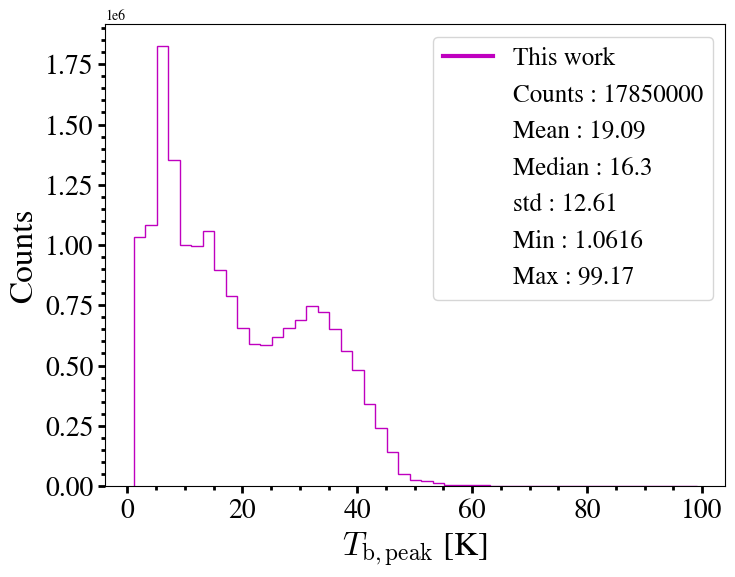

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(tb_peak_map_arr, bins=np.linspace(np.nanmin(tb_peak_map_arr), np.nanmax(tb_peak_map_arr), 50),
         density=False, color='m', histtype='step',
         alpha=1., ls='-', lw=50,
         label='')

ploti, = plt.plot([], [], 'm-', lw=3, label=f'This work')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'$T_\mathrm{b,peak}$ [K]', fontsize=24)
plt.ylabel(r'Counts', fontsize=24)

plt.legend(loc='upper right', fontsize=18)
plt.show()

In [ ]:
galah_gl_coords = SkyCoord(glon_fg, glat_fg, frame='galactic', unit='deg')
print(galah_gl_coords)

<SkyCoord (Galactic): (l, b) in deg
    [(307.33833223, -43.02568216), (307.05440437, -42.27173884),
     (307.37768948, -43.44185215), ..., (286.25580239, -27.89819627),
     (285.95614173, -27.88716795), (286.33041094, -27.8459304 )]>


In [ ]:
galah_x, galah_y = galah_gl_coords.to_pixel(wcs=tb_w)
galah_x

array([ 358.49744728,  365.9011757 ,  368.1337588 , ..., 2743.92953736,
       2784.42129954, 2733.97861841])

In [ ]:
galah_x = np.round(galah_x).astype(int)
galah_y = np.round(galah_y).astype(int)
print(galah_x)
print(galah_y)

print(galah_x[0])
print(galah_y[0])

[ 358  366  368 ... 2744 2784 2734]
[ 839  962  775 ... 3388 3389 3396]
358
839


In [ ]:
# This method also works with arrays of world coordinates
glon_array = np.array([300.0, 290.0, 280.0])
glat_array = np.array([-45.0, -37., -45.0])

pixel_x_array, pixel_y_array = tb_w.wcs_world2pix(glon_array, glat_array, 0)

print(f"\nArray of world coordinates (GLON, GLAT):\n{np.vstack((glon_array, glat_array)).T}")
print(f"Corresponding array of pixel coordinates (x, y):\n{np.vstack((pixel_x_array, pixel_y_array)).T}")

pixel_x_array = np.round(pixel_x_array).astype(int)
pixel_y_array = np.round(pixel_y_array).astype(int)
print(pixel_x_array)
print(pixel_y_array)


Array of world coordinates (GLON, GLAT):
[[300. -45.]
 [290. -37.]
 [280. -45.]]
Corresponding array of pixel coordinates (x, y):
[[1229.70501384  699.04153707]
 [2273.28467214 2000.74277566]
 [3372.32181317  760.75563911]]
[1230 2273 3372]
[ 699 2001  761]


In [ ]:
gaskap_tb_peak_arr = np.zeros_like(ew_ki_ism_fg)
for jj, (galah_xi, galah_yi) in enumerate(zip(galah_x, galah_y)):
    gaskap_tb_peak_arr[jj] = tb_peak_map[galah_yi, galah_xi]

In [ ]:
sel_idx = np.where((gaskap_nhi_thin > 0.) & (gaskap_nhi_thin < 14.) & (gaskap_tb_peak_arr < 60.))[0]
len(sel_idx)

9821

In [ ]:
statpr, statpp = scipy.stats.pearsonr(gaskap_nhi_thin[sel_idx], n_ki_ism_fg[sel_idx])
statspr, statspp = scipy.stats.spearmanr(gaskap_nhi_thin[sel_idx], n_ki_ism_fg[sel_idx])
print('nhi vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('nhi vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

nhi vs nki: pearson coefficient, statistic = 0.2919219524136203 , p-value = 3.372642210451496e-192
nhi vs nki: spearman coefficient, statistic = 0.35969358089835995 , p-value = 8.702910494760537e-298


In [ ]:
statpr, statpp = scipy.stats.pearsonr(gaskap_tb_peak_arr[sel_idx], n_ki_ism_fg[sel_idx])
statspr, statspp = scipy.stats.spearmanr(gaskap_tb_peak_arr[sel_idx], n_ki_ism_fg[sel_idx])
print('tbpeak vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('tbpeak vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

tbpeak vs nki: pearson coefficient, statistic = 0.27675210129831546 , p-value = 3.663925742837823e-172
tbpeak vs nki: spearman coefficient, statistic = 0.33088671187781593 , p-value = 1.4030983107908952e-249


In [ ]:
ki_hi_ratio = n_ki_ism_fg[sel_idx] / gaskap_nhi_thin[sel_idx]

stats_series = pd.DataFrame(ki_hi_ratio).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,9821.000000
mean,2.781584
std,2.137411
min,0.261941
25%,1.521582
50%,2.190110
75%,3.306702
max,41.131644


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 2)
x_std = round(series_values[2], 2)
x_minval = round(series_values[3], 4)
x_maxval = round(series_values[-1], 2)
x_median = round(series_values[5], 2)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

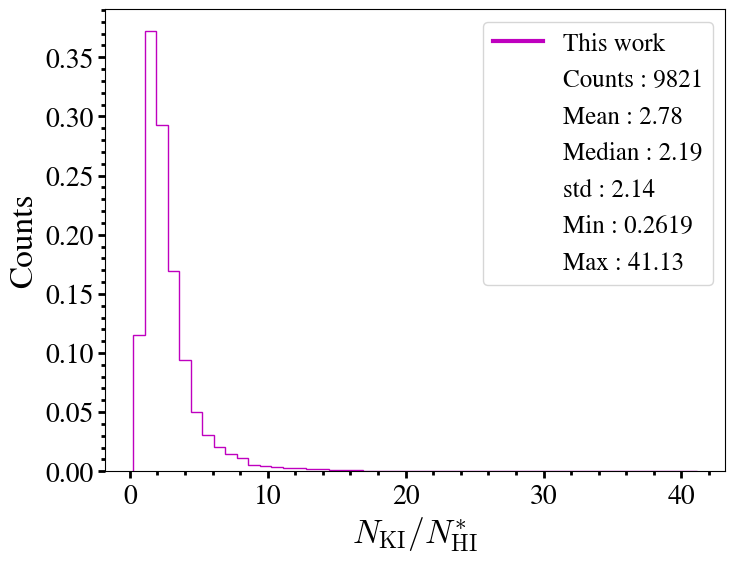

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(ki_hi_ratio, bins=np.linspace(np.nanmin(ki_hi_ratio), np.nanmax(ki_hi_ratio), 50),
         density=True, color='m', histtype='step',
         alpha=1., ls='-', lw=50,
         label='')

ploti, = plt.plot([], [], 'm-', lw=3, label=f'This work')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'$N_\mathrm{KI} / N^{*}_\mathrm{HI}$', fontsize=24)
plt.ylabel(r'Counts', fontsize=24)

plt.legend(loc='upper right', fontsize=18)
plt.show()

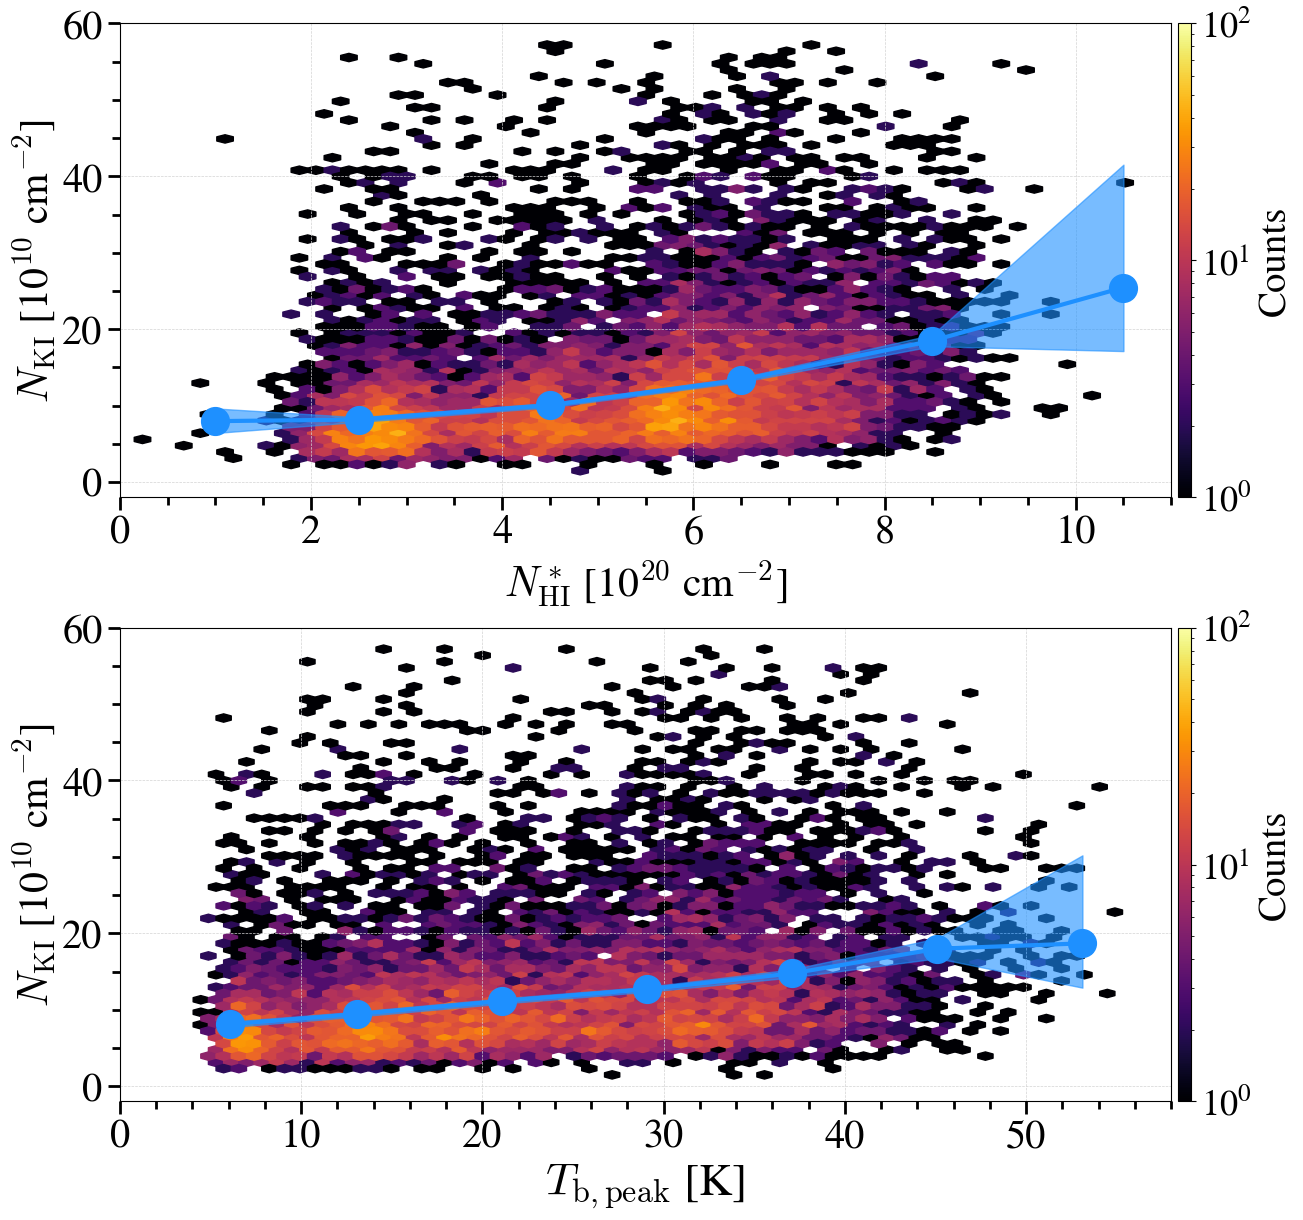

In [ ]:
xlbs = 25
tlbs = 23
cmap = 'viridis'

cm = mpl.colormaps['cool']


# Plot
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(211)

bin_edges = [0.5, 2, 4, 6, 8, 10, 12]
bin_avg, bin_avg_upper, bin_avg_lower = binned_median(gaskap_nhi_thin[sel_idx], n_ki_ism_fg[sel_idx], bin_edges)
x_bin = np.array(bin_edges[:-1]) + 0.5



normalizer = LogNorm(1., 100)
img = ax.hexbin(gaskap_nhi_thin[sel_idx], n_ki_ism_fg[sel_idx], gridsize=60, cmap='inferno', norm=normalizer, zorder=1)


ax.plot(x_bin, bin_avg,
                   zorder=3,
                   marker='o', c='dodgerblue', markersize=20,
                   ls='-', lw=3,
                   label='')

ax.fill_between(x_bin, bin_avg_upper, bin_avg_lower, color='dodgerblue', zorder=2, alpha=0.6, lw=1, label='')

ax.set_ylabel(r'$N_\mathrm{KI}$ [10$^{10}$ cm$^{-2}$]', fontsize=30)
ax.set_xlabel(r'$N^*_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=30, fontweight='normal')


ax.minorticks_on()
ax.tick_params(axis='x', labelsize=29, pad=3)
ax.tick_params(axis='y', labelsize=29)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=6)

ax.set_xlim(0., 11.)
ax.set_ylim(-2, 60)

# Color bar
cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.025, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'Counts', rotation=90, labelpad=5., fontsize=28)
cbar.ax.tick_params(labelsize=26)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)




################
##############

ax = fig.add_subplot(212)

bin_edges = [6., 13., 21, 29, 37, 45, 53., 61.]
bin_avg, bin_avg_upper, bin_avg_lower = binned_median(gaskap_tb_peak_arr[sel_idx], n_ki_ism_fg[sel_idx], bin_edges)
x_bin = np.array(bin_edges[:-1]) + 0.1


normalizer = LogNorm(1., 100)
img = ax.hexbin(gaskap_tb_peak_arr[sel_idx], n_ki_ism_fg[sel_idx], gridsize=60, cmap='inferno', norm=normalizer)

ax.plot(x_bin, bin_avg,
                   zorder=3,
                   marker='o', c='dodgerblue', markersize=20,
                   ls='-', lw=3,
                   label='')

ax.fill_between(x_bin, bin_avg_upper, bin_avg_lower, color='dodgerblue', zorder=2, alpha=0.6, lw=1, label='')



ax.set_ylabel(r'$N_\mathrm{KI}$ [10$^{10}$ cm$^{-2}$]', fontsize=30)
ax.set_xlabel(r'$T_\mathrm{b,peak}$ [K]', fontsize=33, fontweight='normal')


ax.minorticks_on()
ax.tick_params(axis='x', labelsize=29, pad=3)
ax.tick_params(axis='y', labelsize=29)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=6)

ax.set_xlim(0., 58.)
ax.set_ylim(-2, 60)


# Color bar
cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.025, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'Counts', rotation=90, labelpad=5., fontsize=28)
cbar.ax.tick_params(labelsize=26)


ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.,
                    hspace=0.275
                    )



plt.show()

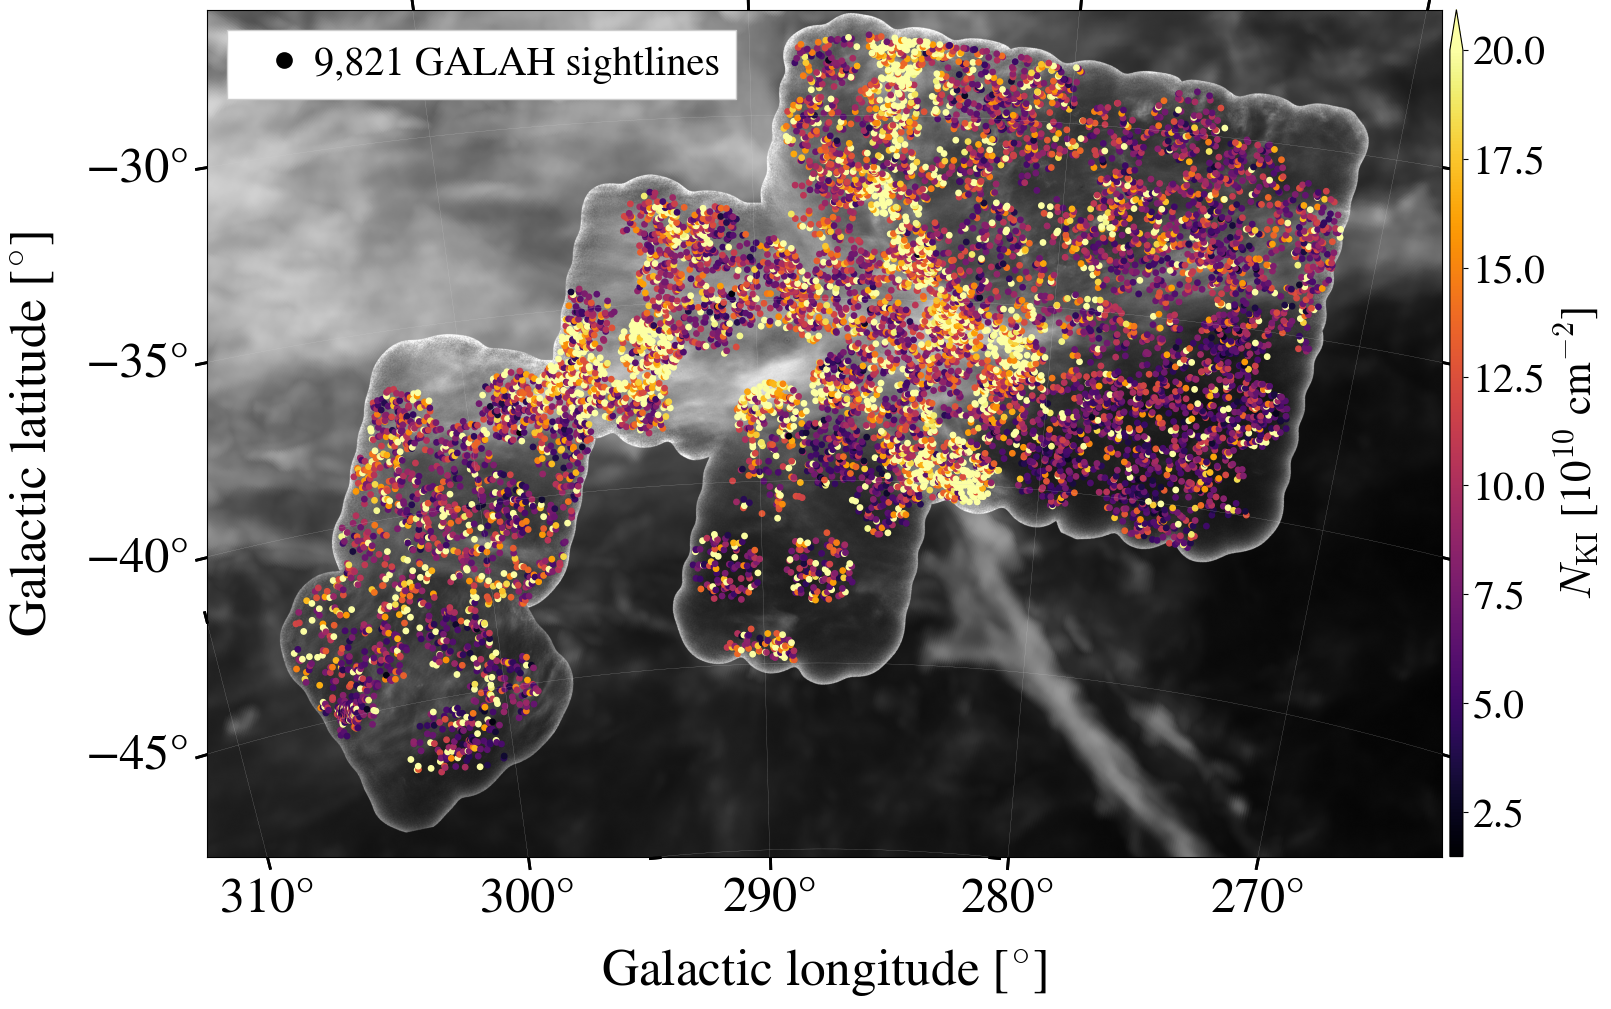

In [ ]:
xlbs = 37
tlbs = 36

cm = mpl.colormaps['inferno']


# Plot
fig = plt.figure(figsize=(18, 11))
ax = fig.add_subplot(111, projection=tb_w)

# Display the moment map image
im = ax.imshow(tb_peak_map, cmap='gray', vmin=0., vmax=60.)

sct = ax.scatter(glon_fg[sel_idx], glat_fg[sel_idx], s=15, c=n_ki_ism_fg[sel_idx], transform=ax.get_transform('galactic'),
           marker='o', cmap=cm, vmin=n_ki_ism_fg[sel_idx].min(), vmax=20.,
           label='')

ploti, = ax.plot([200], [3200], c='k', marker='o', markersize=9, mew=3, ls='', lw=0, label= "{:,} GALAH sightlines".format(len(glon_fg[sel_idx])))
ploti.set_visible(True)


# Add axes labels
ax.set_xlabel(r'Galactic longitude [$^{\circ}$]', fontsize=xlbs)
ax.set_ylabel(r'Galactic latitude [$^{\circ}$]', fontsize=xlbs)


# Color bar
cbar = fig.colorbar(sct, ax=ax, extend='max', orientation='vertical', fraction=0.01, pad=0.006, aspect=65)
cbar.ax.set_ylabel(r'$N_\mathrm{KI}$ [10$^{10}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=31)
cbar.ax.tick_params(labelsize=30)


ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=2)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2, direction='out')
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=5)

ax.set_ylim(0, 3500)

ax.legend(loc='upper left', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', handletextpad=-0.25, fontsize=29)

ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()